In [3]:
#import modules
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import pims
import trackpy as tp
import os
from datetime import datetime
from dateutil import parser
import re

#MatPlotLib
import matplotlib as mpl
import matplotlib.pyplot as plt

#Scikit-image
from skimage.transform import rotate
from skimage.util import crop
from skimage import exposure
from skimage import data, img_as_float, img_as_uint

#magic commands
%matplotlib inline 
%matplotlib notebook

#tweak styles
mpl.rc('figure', figsize = (10,6))
mpl.rc('image', cmap = 'gray')

#get some DeprecationWarnings in sklearn module. Ignore these warnings for now.
import warnings
warnings.filterwarnings('ignore')

SUPPORT FUNCTIONS

In [46]:
def adapthist(im):
    """
    Enhance contrast by adaptive histogram equalization
    """
    
    im_adapteq = exposure.equalize_adapthist(im, clip_limit=0.01)
    
    return im_adapteq

def showim2(im1, im2):
    """
    Show two images side-by-side
    """
    #Show images
    f, ax = plt.subplots(1, 2, sharey=True)
    plt.axes(ax[0])
    plt.imshow(im1)
    plt.axes(ax[1])
    plt.imshow(im2)

def showparticle(trajectory, particle, framelist):
    """
    Show specific particle for frames specified in framelist
    """
    #select rows for corresponding particle and sort by frame
    select_traj = trajectory[trajectory['particle']==4].sort_values(['frame'], ascending=True)

    #loop by frames
    fig = -1
    for f in framelist:
        data = select_traj[select_traj['frame'] == f]
        fig = plt.figure()
        tp.annotate(data, image, plot_style={'markersize':5, 'markeredgewidth':1})
        fig.suptitle("Frame:" + str(f))


def timestamp(frameinterval):
    """
    return complete time stamp from MetaMorph tiff file
    """

    frameseq = np.arange(frameinterval[0],frameinterval[1]+1,1)
    #new pandas data frame to store time information
    df_ = pd.DataFrame(columns=['year','month','day','hour','minute','second','millisecond'])

    for f in frameseq:
        #extract meta data
        metadata = str(frames[f].metadata['ImageDescription'])
    
        #find the correct time stamp string between two consistent fields in metadata
        sub1 = '<prop id="acquisition-time-local" type="time"'
        sub2 = '<prop id="modification-time-local" type="time"'
        ix1 = metadata.find(sub1)
        ix2 = metadata.find(sub2)
        metadata2 = metadata[ix1:ix2]

        #remove parenthesis from string
        metadata3 = re.sub('\"','', metadata2)
        #search for the exact time string
        match = re.search(r'\d{8} \d{2}:\d{2}:\d{2}.\w+', metadata3)
        #now, strip the time and date values from the time string
        TO = datetime.strptime(match.group(), '%Y%m%d %H:%M:%S.%f')
        #add data to data frame
        df_.loc[f] = [TO.year,TO.month,TO.day,TO.hour,TO.minute,TO.second,TO.microsecond/1000]
    
    return(df_)
    
def partparms(trajectory):
    """
    IN: trajectories OUT: particle_data = ['particle','r0_um','r1_um','dist_um','dt_s','vel_umps']
    """
    #create empty output data frame
    dfcols = ['particle','r0_um','r1_um','dist_um','dt_s','vel_umps']    
    particle_data = pd.DataFrame(columns=dfcols)
    #store particle numbers
    partnumbers = np.sort(trajectory['particle'].unique())
    
    for p in partnumbers:
        
        #filter single particle trajectory and sort by frame number
        trajectory_p = pd.DataFrame(trajectory[trajectory['particle'] == p].sort_values(['frame'], ascending=True))
        #create empty data frame for trajectory p
        df_ = pd.DataFrame(columns=dfcols)
        
        for line in range(1,len(trajectory_p)):
            dframe = trajectory_p.iloc[line,-2] - trajectory_p.iloc[line-1,-2]
            dt = dframe * scaninterval / 1000 #[s]
            r0 = np.array([trajectory_p.iloc[line-1,0] * pixel_calibration_x, trajectory_p.iloc[line-1,1] * pixel_calibration_y])
            r1 = np.array([trajectory_p.iloc[line,0] * pixel_calibration_x, trajectory_p.iloc[line,1] * pixel_calibration_y])
            dist = np.linalg.norm(r1-r0) #[um]
            vel = dist/dt #[um/s]
            #record entries only if dframe = 1. A jump in frame number indicates that the particle was lost
            if dframe == 1:
                df_.loc[len(df_)] = [p,r0,r1,dist,dt,vel]
        
        #add the data to to output array
        particle_data = particle_data.append(df_, ignore_index = True)
        
    return(particle_data)

def stat_partparms(particle_data):
    """
    IN: particle_data OUT: mean_particle_data = ['particle','r0_um','r1_um','dist_um','dt_s','vel_umps']
    """
    #prepare output data frame
    dfcols = ['particle','total_dist_um','total_time_s','mean_vel_umps'] 
    stat_particle_data = pd.DataFrame(columns=dfcols)

    #loop over all particles
    partnumbers = np.sort(trajectory['particle'].unique())
    for p in partnumbers:
       
        #filter single particle trajectory and sort by frame number
        particle_data_p = particle_data[particle_data['particle'] == p]
        #create empty data frame for trajectory p
        total_dist_um = particle_data_p['dist_um'].sum()
        total_time_s = particle_data_p['dt_s'].sum()
        mean_vel_umps = particle_data_p['vel_umps'].mean()
        
        #add results to the output data frame
        stat_particle_data.loc[len(stat_particle_data)] = [p, total_dist_um, total_time_s, mean_vel_umps]
        
    return(stat_particle_data)

#def filter_trajectories_size(trajectory, stat_particle_data):
    

In [88]:
#def filter_trajectory_size(trajectory, stat_particle_data, size):
#trajectory = trajsF1.copy()
#stat_particle_data = stat_partparms(partparms(trajectory))
#find those particles that have a trajectory length size or larger
size = 20
filtered_stat = stat_particle_data[stat_particle_data['total_dist_um'] >= size]
#figure out the particle numbers
particle_numbers = np.array(filtered_stat['particle'])
#select those numbers in the trajectory frame
filtered_trajectory = trajectory[trajectory['particle'] == 2]

Data file and path information

In [47]:
filedir = os.getcwd() + '\\BLOODFLOWDATA'
resultsdir = os.getcwd() + '\\RESULTS'
filename = 'H160122-X10-TAILEND3-FL80FPS.tif'
file = os.path.join(filedir, filename)
#frames = pims.TiffStack(file)
frames = pims.TiffStack(file, process_func=adapthist)
#metadata
metadata = frames[0].metadata['ImageDescription']

In [4]:
print(metadata)

('<MetaData>\n<prop id="Description" type="string" value="Acquired from AndorSdk3 Camera&#13;&#10;Exposure: 5 msec&#13;&#10;Binning: 1 X 1&#13;&#10;Region: 256 x 216, offset at (0, 0)&#13;&#10;Digitizer: 200 MHz - lowest noise&#13;&#10;Gain: 11-bit (high well capacity)&#13;&#10;Cooler On: 1&#13;&#10;Camera State: Non-Overlapped&#13;&#10;"/>\n<prop id="MetaDataVersion" type="float" value="1"/>\n<prop id="ApplicationName" type="string" value="MetaMorph"/>\n<prop id="ApplicationVersion" type="string" value="7.8.10.0"/>\n<PlaneInfo>\n<prop id="plane-type" type="string" value="plane"/>\n<prop id="pixel-size-x" type="int" value="256"/>\n<prop id="pixel-size-y" type="int" value="216"/>\n<prop id="bits-per-pixel" type="int" value="16"/>\n<prop id="autoscale-state" type="bool" value="off"/>\n<prop id="autoscale-min-percent" type="float" value="0"/>\n<prop id="autoscale-max-percent" type="float" value="0"/>\n<prop id="scale-min" type="int" value="100"/>\n<prop id="scale-max" type="int" value="40

Calibrations

In [48]:
#Microscope calibrations
print('Pixel calibration for Andor Neo sCMOS 2560 x 2160 camera')
print('Image file: ', filename)
objective_magnification = 10
sideport_magnification = 0.38
chip_size_x = 16.6 #full frame chip size X [mm]
chip_size_y = 14.0 #full frame chip size Y [mm]
chip_pixels_x = 2560 #full frame chip size X [pixels]
chip_pixels_y = 2160 #full frame chip size Y [pixels]
field_ratio_x = frames[0].shape[1] / chip_pixels_x
field_ratio_y = frames[0].shape[0] / chip_pixels_y
field_size_x = chip_size_x * field_ratio_x / objective_magnification / sideport_magnification
field_size_y = chip_size_y * field_ratio_y / objective_magnification / sideport_magnification
pixel_calibration_x = chip_size_x * 1000 / chip_pixels_x / objective_magnification / sideport_magnification
pixel_calibration_y = chip_size_y * 1000 / chip_pixels_y / objective_magnification / sideport_magnification
pixel_calibration = np.mean([pixel_calibration_x, pixel_calibration_y]) #mean value to convert pixels into microns
print('pixel_calibration_x = ', '%.3f' % pixel_calibration_x, '[um/pixel]')
print('pixel_calibration_y = ', '%.3f' % pixel_calibration_y, '[um/pixel]')
print('field_size_x = ', '%.2f' % field_size_x, '[mm]')
print('field_size_y = ', '%.2f' % field_size_y, '[mm]')
#date and frame rate
stamp = timestamp([0,10])
frame_year = int(stamp['year'][0])
frame_month = int(stamp['month'][0])
frame_day = int(stamp['day'][0])
time =stamp['minute'] * 60 * 1000 + stamp['second'] * 1000 + stamp['millisecond']
timearray = np.array(time)
dtlist = [(timearray[i]-timearray[i-1]) for i in np.arange(1,len(timearray),1)]
scaninterval = np.mean(dtlist)
scanrate = 1/scaninterval * 1000
print('mean scan interval = ', scaninterval, '[ms]')
print('mean frame rate = ', scanrate, '[fps]')

Pixel calibration for Andor Neo sCMOS 2560 x 2160 camera
Image file:  H160122-X10-TAILEND3-FL80FPS.tif
pixel_calibration_x =  1.706 [um/pixel]
pixel_calibration_y =  1.706 [um/pixel]
field_size_x =  0.44 [mm]
field_size_y =  0.37 [mm]
mean scan interval =  8.3 [ms]
mean frame rate =  120.481927711 [fps]


LOCATE FEATURES

<IPython.core.display.Javascript object>


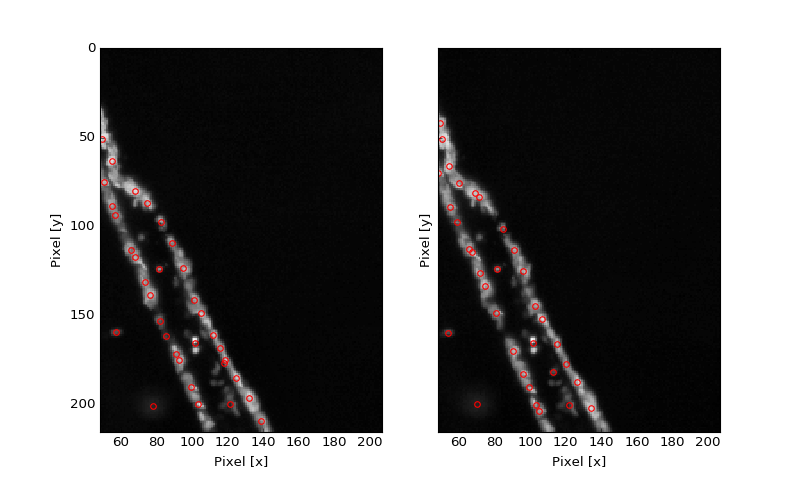

[None, None]

In [49]:
#Locate features
fnumber = 50 #current frame to look at
diam = 11 #odd integer with features extent in pixels
minm = 0.03 #minimum integrated brightness
sep = 1 #minimum separation between features
perc = 20 #features must have a peak brighter than pixels in this percentile
topnum = 500 #return only the N brightest features above minmass

feats1 = tp.locate(frames[fnumber], invert=False, diameter=diam, minmass=minm, separation=sep, percentile=perc,
                  topn=topnum)
feats2 = tp.locate(frames[fnumber+10], invert=False, diameter=diam, minmass=minm, separation=sep, percentile=perc,
                  topn=topnum)

f, ax = plt.subplots(1, 2, sharey=True)
plt.axes(ax[0])
tp.annotate(feats1, frames[fnumber], plot_style={'markersize':5, 'markeredgewidth':1})

plt.axes(ax[1])
tp.annotate(feats2, frames[fnumber+10], plot_style={'markersize':5, 'markeredgewidth':1})

#set axis properties
[ax[i].set_xlabel('Pixel [x]') for i in range(2)]
[ax[i].set_ylabel('Pixel [y]') for i in range(2)]
[ax[i].legend_.remove() for i in range(2)]

FIND FEATURES IN ALL FRAMES

In [20]:
feats = tp.batch(frames, diameter=diam, minmass=minm, separation=sep, invert=False, percentile=perc,
                 topn=topnum)

Frame 499: 49 features


LINK FEATURES INTO PARTICLE TRAJECTORIES

In [21]:
searchrange = 5 #Maximum distance features can move between frames
memory = 3 #Maximum number of frames during which a feature can vanish, than reappear and consider the same particle
trajs = tp.link_df(feats, 5, memory=3)

Frame 499: 49 trajectories present


FILTER TRAJECTORIES

In [50]:
#get rid of spurious trajectories (minimum number of frames)
trajsF1 = tp.filter_stubs(trajs, threshold = 10)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', trajs['particle'].nunique())
print('After:', trajsF1['particle'].nunique())

Before: 1010
After: 530


In [52]:
#Our goal: a histogram of the trajectory lengths
#and then, filter the particles that have the longest trajetories
#calculate distances and velocities for each particle
#OUT: np.array(particle#, diag_size, total_dist, mean_vel)
p_parms = partparms(trajsF1) 

In [53]:
#some simple statistics for each particle
p_parms_stat = stat_partparms(p_parms)

In [55]:
p_parms.head()

,particle,r0_um,r1_um,dist_um,dt_s,vel_umps
0,2,"[44.5518538075, 34.5866473849]","[44.9339054968, 28.0857193421]",6.512145,0.0083,784.595750
1,2,"[44.9339054968, 28.0857193421]","[46.856988684, 26.6769974943]",2.383851,0.0083,287.210979
2,2,"[46.856988684, 26.6769974943]","[47.6099501825, 27.235630824]",0.937562,0.0083,112.959259
3,2,"[47.6099501825, 27.235630824]","[48.6328125, 27.6649720644]",1.109316,0.0083,133.652488
4,2,"[48.6328125, 27.6649720644]","[48.4984369938, 29.6241423214]",1.963773,0.0083,236.599171


<IPython.core.display.Javascript object>


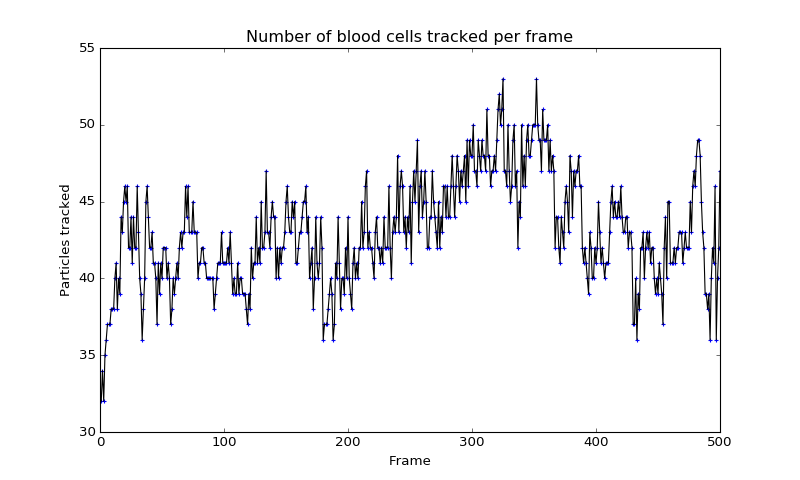

In [66]:
#particle tracking statistics
basename = filename[:-4] +'_'

#Number of tracked blood cells per frame
fnumbers = trajsF1['frame'].unique()
PartPerFrame = [trajsF1[trajsF1['frame']==fnumbers[i]].shape[0] for i in fnumbers]
fx = np.arange(1,len(PartPerFrame)+1,1)
plt.figure()
ax0=plt.axes()
ax0.scatter(x=fx, y=PartPerFrame, s=20, marker='+', linewidths=1)
PartLine = mpl.lines.Line2D(xdata=fx,ydata=PartPerFrame, linewidth=1, color='black')
ax0.add_line(PartLine)
ax0.axis(xmin=0, xmax=len(frames))
ax0.set_xlabel('Frame')
ax0.set_ylabel('Particles tracked')
ax0.set_title('Number of blood cells tracked per frame')
f = resultsdir + '\\' + basename + 'ClsPerFrame.png'
plt.savefig(f, pad_inches = 0)

In [73]:
#particle tracking statistics
basename = filename[:-4] +'_'

#plot trajectories
plt.figure('Raw particle trajectories')
ax0=plt.axes()
plt.axes(ax0)
tp.plot_traj(trajsF1)
plt.gca().legend_.remove()
ax0.set_xlabel('X [pixels]')
ax0.set_ylabel('Y [pixels]')
ax0.invert_yaxis()
ax0.set_title('All trajectories ' + filename[:-4])
#save image
sname = resultsdir + '\\' + filename[:-4] + 'Traj.png'
plt.savefig(sname)


0.15415262566690194

In [58]:
#particle tracking statistics
basename = filename[:-4] +'_'

#Number of tracked blood cells per frame
fnumbers = trajsF1['frame'].unique()
PartPerFrame = [trajsF1[trajsF1['frame']==fnumbers[i]].shape[0] for i in fnumbers]
fx = np.arange(1,len(PartPerFrame)+1,1)
plt.figure()
ax0=plt.axes()
ax0.scatter(x=fx, y=PartPerFrame, s=20, marker='+', linewidths=1)
PartLine = mpl.lines.Line2D(xdata=fx,ydata=PartPerFrame, linewidth=1, color='black')
ax0.add_line(PartLine)
ax0.axis(xmin=0, xmax=len(frames))
ax0.set_xlabel('Frame')
ax0.set_ylabel('Particles tracked')
plt.savefig(basename + 'CellsPerFrame')

#hist: Diagonal trajectory size
plt.figure('Diagonal trajectory sizes')
ax1=plt.axes()
maxdist = np.floor(np.linalg.norm(frames[0].shape)) # diagonal image size
ax1.hist(p_parms[:,1], histtype='bar', color='red', bins=10)
ax1.axis(xmin=0, xmax=maxdist)
ax1.set_xlabel('Diagonal trajectory size (px)')
ax1.set_ylabel('Frequency')
plt.savefig(basename + 'DiagSize')

#hist: Total distance travelled
plt.figure('Total distance tracked')
ax2=plt.axes()
ax2.hist(p_parms[:,2], histtype='bar', color='blue', bins=20)
ax2.axis(xmin=0, xmax=maxdist)
ax2.set_xlabel('Total distance travelled (px)')
ax2.set_ylabel('Frequency')

#hist Mean particle velocity
plt.figure('Mean particle velocity')
ax3=plt.axes()
ax3.hist(p_parms[:,3], histtype='bar', color='green', bins=20)
#ax3.axis(xmin=0, xmax=2)
ax3.set_xticks(np.arange(0,1.5,0.2), minor=True)
ax3.set_xlabel('Particle velocity [px/frame]')
ax3.set_ylabel('Frequency')

#Particle velocity as a function of distance travelled
#Does the tracked distance matter for the velocity calculation?




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

TypeError: unhashable type: 'slice'

In [57]:
basename = resultsdir + '\\' + filename[:-4] +'_'
basename

'D:\\Dropbox\\D_PROGRAMMING\\GIT\\Python_Bloodflow\\RESULTS\\H160122-X10-TAILEND3-FL80FPS_'

In [135]:
np.arange(0,2,0.5)

array([ 0. ,  0.5,  1. ,  1.5])